<img src="../images/logos/ClimKern-logo.png" width=250 alt="ClimKern Python Package Logo"></img>

# Feedbacks with ClimKern

---

## Overview

While it is good to know how to manually calculate radiative feedbacks, it is also time-consuming to constantly recreate the code. Here, we will use a new Python package called ClimKern that offers functions to calculate radiative feedbacks from climate model or reanalysis output. The advantages of using ClimKern go beyond making it simpler—it standardizes the methods and assumptions that go into these sometimes complicated calculations. We will use CMIP6 output in this notebook.

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | |
| [Loading CMIP6 Data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm.html) | Helpful | | 

- **Time to learn**: 20 minutes

---

## Imports

In [1]:
import climkern as ck
import intake
import matplotlib.pyplot as plt
import s3fs
import fsspec
import xarray as xr
import glob
import importlib.util
import os
import cartopy.crs as ccrs

%matplotlib inline
plt.rcParams["figure.dpi"] = 100

## Download the kernel

Normally, when ClimKern is installed, the user needs to download data on the command
line from the Zenodo repository. However, we now have the data on Jetstream2, so
we can download it from there and save it in our package repository.

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Future update</p>
    Future versions of ClimKern will be able to pull the kernel from Jetstream2 without
    storing locally.
</div>

First, set the URL and path to point to ClimKern. Also, specify which kernel you want.

In [2]:
URL = "https://js2.jetstream-cloud.org:8001/" # URL for jetstream access
path = f"pythia/ClimKern" # Location of ClimKern
kernel = "ERA5"

Next, read in the data from Jetstream2

In [3]:
# Read in data
# Set up access to jetstream2
fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))
pattern = f"s3://{path}/kernels/"+kernel+f"/TOA*.nc"

# Grab the data
files = sorted(fs.glob(pattern))

# Open file and make it Xarray Dataset
kern = xr.open_dataset(fs.open(files[0]))

# Save path for later
path_out = files[0].split(kernel+"/",1)[1]

To save this data in ClimKern's directory, we have to figure out where it is on the
machine. After that, we will go ahead anad save out the kernel as a netCDF in 
ClimKern's local data directory.

In [4]:
# Get the package location
spec = importlib.util.find_spec("climkern")
package_dir = os.path.dirname(spec.origin)

# print(f"The package directory is: {package_dir}")

# Define the path where you want to save the netCDF file within the package directory
netcdf_path = os.path.join(package_dir,"data/kernels",kernel,path_out)

# Ensure the directory exists
os.makedirs(os.path.dirname(netcdf_path), exist_ok=True)

# Save the dataset as a netCDF file
kern.to_netcdf(netcdf_path)

Now, let's just make sure we can retrieve the kernel.

In [5]:
ck.util.get_kern(kernel)

<xarray.Dataset> Size: 228MB
Dimensions:   (plev: 37, lat: 73, lon: 144, time: 12)
Coordinates:
  * plev      (plev) float32 148B 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * lat       (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon       (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    lwclr_t   (time, plev, lat, lon) float64 37MB ...
    lw_t      (time, plev, lat, lon) float64 37MB ...
    lwclr_q   (time, plev, lat, lon) float64 37MB ...
    lw_q      (time, plev, lat, lon) float64 37MB ...
    swclr_q   (time, plev, lat, lon) float64 37MB ...
    sw_q      (time, plev, lat, lon) float64 37MB ...
    swclr_a   (time, lat, lon) float64 1MB ...
    sw_a      (time, lat, lon) float64 1MB ...
    lwclr_ts  (time, lat, lon) float64 1MB ...
    lw_ts     (time, lat, lon) float64 1MB ...

## Prepare the CMIP6 Data

To start, we will need some CMIP6 data to calculate feedbacks. We will use the
preindustrial control and 4×CO$_2$ experiments from just one model (CESM2).

In [6]:
# Make a list of variables and experiments we need
var_list = ["rsds","rsus","ta","ts","ps"]
exp_list = ["piControl","abrupt-4xCO2"]

# Specify data location, open it
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

# Create a catalog of matching simulations
cat = col.search(experiment_id=exp_list,source_id="CESM2",variable_id=var_list,
                table_id="Amon")

# Convert to a dictionary of Xarray Datasets
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


The data, especially the preindustrial control simulation that will serve as our
control climate, is huge. We are going to only use the last 50 years of the control
and last 30 years of the abrupt 4×CO$_2$ simulation. There are a few extra coordinates
and/or dimensions we don't need, hence the `squeeze()`.

In [7]:
# Our control simulation
ctrl = ds_dict["CMIP.NCAR.CESM2.piControl.Amon.gn"].isel(
    time=slice(-600,None)).squeeze().chunk({"plev":1,"time":-1})

# The increase CO2 aka "perturbed" simulation
pert = ds_dict["CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn"].isel(
    time=slice(-360,None)).squeeze().chunk({"plev":1,"time":-1})

To save a little diskspace because ClimKern still isn't dask compatible yet,
let's make our control climatology ahead of time.

In [8]:
ctrl = ctrl.groupby(ctrl.time.dt.month).mean(dim="time").rename({"month":"time"})
pert = pert.groupby(pert.time.dt.month).mean(dim="time").rename({"month":"time"})

## Feedback calculations

### Surface albedo feedback

Perhaps the simplest of the radiative feedbacks to calculate is the surface albedo
feedback because it requires only two variables and is a 3-dimensional field (no height
coordinate). The variables we will use are as follows:

| Variable name | Description | Units |
| --- | --- | --- |
|<i>rsus</i> | The upwelling shortwave radiation at the surface | W/m$^2$ |
|<i>rsds</i> | The downwelling shortwave radiation at the surface | W/m$^2$ |


The [`calc_alb_feedback()`](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_alb_feedback) function is straightforward. Be sure to include our kernel name
in the arguments.

In [9]:
alb = ck.calc_alb_feedback(
    ctrl.rsus,ctrl.rsds,pert.rsus,pert.rsds,kern="ERA5"
)

Let's see what the resulting Dataarray looks like.

In [10]:
alb

<xarray.DataArray (time: 12, lat: 192, lon: 288)> Size: 5MB
dask.array<mul, shape=(12, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
  * time            (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

A few notes:
* The output from ClimKern is always in units of W/m$^2$. Therefore, this should be interpretted as the radiative perturbation from the surface albedo feedback at the top-of-atmosphere.
* The output is 3-dimensional with coordinates of lat, lon, and time.

Finally, let's plot the time average surface albedo feedback on a map.

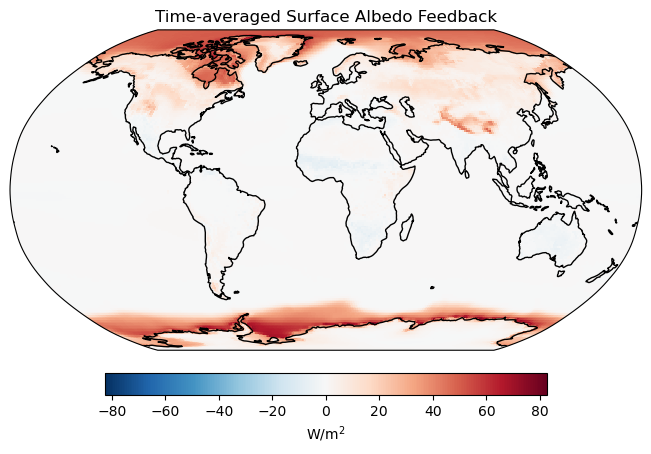

In [11]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
alb.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Surface Albedo Feedback")

plt.show()

As one might expect, the greatest radiative change at the TOA from the surface albedo feedback is near the poles where there is melting sea ice and snow.

### Planck and lapse rate feedbacks

As a reminder, the total tropospheric temperature feedback is often decomposed into a distict Planck and lapse rate feedback. ClimKern has a single function that produces both feedbacks simultaneously called [`calc_T_feedbacks()`](https://tyfolino.github.io/climkern/climkern.html#climkern.calc_T_feedbacks). The variables we need this time are:

| Variable name | Description | Units | Notes |
| --- | --- | --- | --- |
|<i>ta</i> | The 4-dimensional air temperature | K | |
|<i>ts</i> | The 3-dimensional surface skin temperature | K | |
|<i>ps</i> | The 3-dimensional surface pressure | Pa, mb, or hPa| |
|<i>trop_p</i> | The 3-dimensional tropopause height | Pa, mb, or hPa | <i>Optional</i> |

CMIP6 output rarely contains the tropopause height, so we will create a default tropopause that decreases linearly with the cosine of latitude from 100 hPa at the Equator to 300 hPa at the poles.

In [12]:
# Use ClimKern's "hidden" make_tropo function
pert["trop_p"] = ck.util.make_tropo(pert.ps)
pert.trop_p.attrs["units"] = "Pa"

lr,pl = ck.calc_T_feedbacks(
    ctrl.ta,ctrl.ts,ctrl.ps,pert.ta,pert.ts,pert.ps,pert_trop=pert.trop_p,kern="ERA5"
)

Simple. Let's see what it looks like.

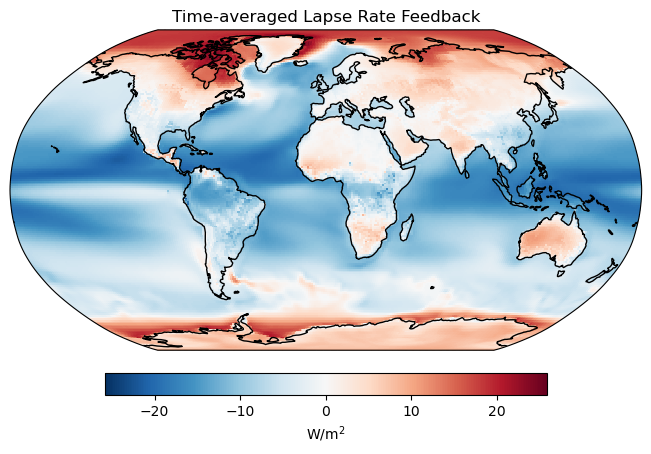

In [13]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
lr.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Lapse Rate Feedback")

plt.show()

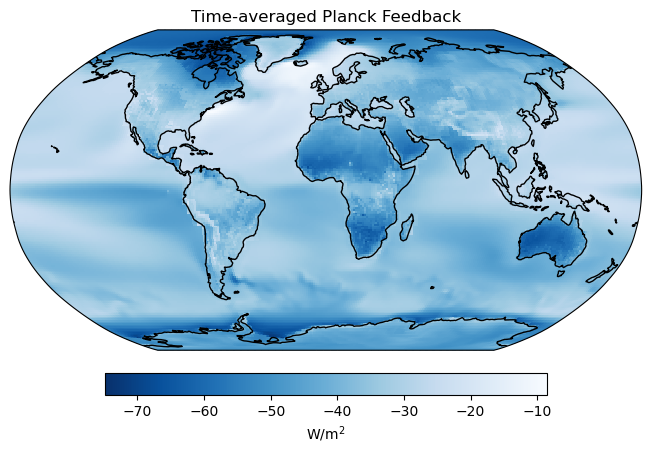

In [14]:
# Set a few variables
proj = ccrs.Robinson()

# Create figure and axis
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),
                       layout="constrained")

# Plot surface albedo feedback & add coastlines
pl.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Blues_r",
                         cbar_kwargs={"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$"})
ax.coastlines()

# Add a title
ax.set_title("Time-averaged Planck Feedback")

plt.show()

### Water vapor feedbacks

### Cloud feedbacks

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
new = "helpful information"

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!